# Descriptive 1-2

In the following section, we'll compare the language and the runtime of the top 250 movies on douban and imdb respectively.

## Languages

First, we'll have a look at what languages are most common among the top 250 movies on each website.

In [1]:
import pandas as pd
import csv
from os import sep

douban_df = pd.read_csv("douban_movie_all.csv")
imdb_df = pd.read_csv(f"imdb_movie_all.csv")

In [2]:
douban_df.columns = ['Name', 'Year', 'Rate', 'Directors', 'Writers', 'Stars', 'Genres', 'Country', 'Language', 'Runtime']

In [3]:
display(douban_df.head(3))
display(imdb_df.head(3))

,Name,Year,Rate,Directors,Writers,Stars,Genres,Country,Language,Runtime
0,肖申克的救赎,1994,9.7,弗兰克·德拉邦特,弗兰克·德拉邦特 / 斯蒂芬·金,蒂姆·罗宾斯 / 摩根·弗里曼 / 鲍勃·冈顿 / 威廉姆·赛德勒 / 克兰西·布朗 / 吉...,剧情/犯罪,美国,英语,142分钟
1,霸王别姬,1993,9.6,陈凯歌,芦苇 / 李碧华,张国荣 / 张丰毅 / 巩俐 / 葛优 / 英达 / 蒋雯丽 / 吴大维 / 吕齐 / 雷汉...,剧情/爱情/同性,中国大陆 / 中国香港,汉语普通话,171分钟
2,阿甘正传,1994,9.5,罗伯特·泽米吉斯,艾瑞克·罗斯 / 温斯顿·格鲁姆,汤姆·汉克斯 / 罗宾·怀特 / 加里·西尼斯 / 麦凯尔泰·威廉逊 / 莎莉·菲尔德 / ...,剧情/爱情,美国,英语,142分钟


,Name,Year,Rate,Level,Directors,Writers,Stars,Genres,Runtime,Country,Language,Budget,Box_Office_USA,Box_Office_World
0,The Shawshank Redemption,1994,9.3,IIB,Frank Darabont,Stephen King/Frank Darabont,Tim Robbins/Morgan Freeman/Bob Gunton/See full...,Drama,142 min,USA,English,"$25,000,000","$28,699,976","$28,817,291"
1,The Godfather,1972,9.2,IIB,Francis Ford Coppola,Mario Puzo/Francis Ford Coppola/1 more credit,Marlon Brando/Al Pacino/James Caan/See full ca...,Crime/Drama,175 min,USA,English/Italian/Latin,"$6,000,000","$134,966,411","$246,120,986"
2,The Godfather: Part II,1974,9.0,IIB,Francis Ford Coppola,Francis Ford Coppola/Mario Puzo/1 more credit,Al Pacino/Robert De Niro/Robert Duvall/See ful...,Crime/Drama,202 min,USA,English/Italian/Spanish/Latin/Sicilian,"$13,000,000","$47,834,595","$48,035,783"


In [4]:
import warnings
warnings.filterwarnings("ignore")

def calc_lang(demo, name="imdb"):
    
    demo['l_Language'] = demo['Language'].fillna("").map(lambda x: x.replace(' ', '').split("/"))
    # del demo['Language']
    # display(demo.head(3))
    
    temp_df = demo['l_Language'].apply(pd.Series)
    try: 
        temp_df = temp_df.rename(columns = lambda x : 'tag_' + str(x+1))
        temp_df.fillna(pd.NA,inplace=True)
    except TypeError:
        pass
    temp_df.sample(3)
    
    tags_df = temp_df.merge(demo[["Rate"]], left_index=True, right_index=True,how="left")
    tags_df.sample(3)
    
    rowtags_df = tags_df.melt(id_vars = ['Rate'], value_name = "tag")
    rowtags_df.sort_values("Rate").head(3)
    
    rowtags_df.dropna(inplace=True)
    del rowtags_df["variable"]
    # display(rowtags_df.head(3))
    
    count_df = pd.DataFrame(rowtags_df['tag'].value_counts())
    count_df['id'] = range(1, len(count_df)+1)
    count_df['language'] = count_df.index
    count_df.set_index('id', inplace=True)
    count_df.columns = ["count", "language"]
#     display(count_df)
    top_ten = count_df.head(10)
    
# This changes Chinese into English
    if count_df['language'][1] != "English":
        name = "Douban"
        translation = {"英语":"English", "日语":"Japanese", "汉语普通话":"Mandarin", "法语":"French",
                       "德语":"German", "粤语":"Cantonese", "意大利语":"Italian", "西班牙语":"Spanish",
                       "俄语":"Russian", "韩语":"Korean"}
        top_ten['language'] = top_ten['language'].map(translation)
    
    print("\nThese are the most common languages of the movies on {}:\n".format(name))
    display(top_ten.head(10))

In [5]:
calc_lang(douban_df)
calc_lang(imdb_df)


These are the most common languages of the movies on Douban:



,count,language
id,,
1,164,English
2,46,Japanese
3,42,Mandarin
4,39,French
5,27,German
6,25,Cantonese
7,19,Italian
8,15,Spanish
9,12,Russian



These are the most common languages of the movies on imdb:



,count,language
id,,
1,200,English
2,43,French
3,36,German
4,30,Spanish
5,26,Japanese
6,26,Italian
7,15,Russian
8,13,Latin
9,8,Arabic


As is shown above, English, Japanese, French, German, Italian, Spanish and Russian are in both dataframes. This indicates that both users on Douban and imdb like movies that use those languages. Meanwhile,  mandarin, cantonese and Korean only appear in the first dataframe of Douban while Latin, Hindi and Arabic only appears in the latter of imdb. This is because users of Douban are mostly Chinese and watched more movies in mandarin and cantonese, and vice versa.

## Runtime

Then we are going to see whether runtime affects users' ratings towards the films.

In [6]:
import re
import numpy as np
import seaborn as sns

pattern = re.compile(r'\d+')

def parse_time(time):
    if time is not np.NaN:
        time = re.findall(pattern, time)
        return time[0]
    else:
        return np.NaN

def calc_time(demo):
    demo_df = demo[['Rate', 'Runtime']]
    demo_df.dropna(inplace=True)
    demo_df['Time(min)'] = demo_df['Runtime'].map(parse_time)

    demo_df['Rate_p'] = demo_df['Rate'].map(lambda x: float(x) // 0.5 / 2)
    
    # display(demo_df.head(3))
    
    l = [9.5, 9, 8.5, 8]
    ave = []
    
    for i in l:
        rate_m = demo_df['Rate_p'] == i
        demo_df_rated = demo_df[rate_m]
        cnt = 0
        tt = 0
        for t in demo_df_rated['Time(min)']:
            tt += int(t)
            cnt += 1
        if cnt != 0:
            a = tt / cnt
            ave.append([i, a])
        else:
            ave.append([i, np.NaN])
        
    ave_df = pd.DataFrame(ave)
    ave_df.columns = ["RateGroup", "average_time"]
    display(ave_df)

In [7]:
def disp_joint(demo, name):
    demo_df = demo[['Rate', 'Runtime']]
    demo_df.dropna(inplace=True)
    demo_df['Time(min)'] = demo_df['Runtime'].map(parse_time)

    demo_df['Rate_p'] = demo_df['Rate'].map(lambda x: float(x) // 0.5 / 2)
    
    dist1 = [int(i) for i in demo_df["Time(min)"].values]
    dist2 = [i for i in demo_df["Rate"].values]
    print('\t\t\t'+name)
    ax = sns.jointplot(x=dist2, y=dist1, kind='hex')
    ax.set_axis_labels('Rate', 'Runtime', fontsize=10)
    print()
    
def disp_box(demo, name):
    demo_df = demo[['Rate', 'Runtime']]
    demo_df.dropna(inplace=True)
    demo_df['Time(min)'] = demo_df['Runtime'].map(parse_time)

    demo_df['Rate_p'] = demo_df['Rate'].map(lambda x: float(x) // 0.5 / 2)
    
    dist1 = [int(i) for i in demo_df["Time(min)"].values]
    dist3 = [i for i in demo_df["Rate_p"].values]
    ax = sns.boxplot(x=dist3,y=dist1)
    ax.set(xlabel='Rate(Group)', ylabel='Runtime', title=name+"\n")
    print()

,RateGroup,average_time
0,9.5,139.000000
1,9.0,128.776471
2,8.5,118.525974
3,8.0,123.500000


			Douban



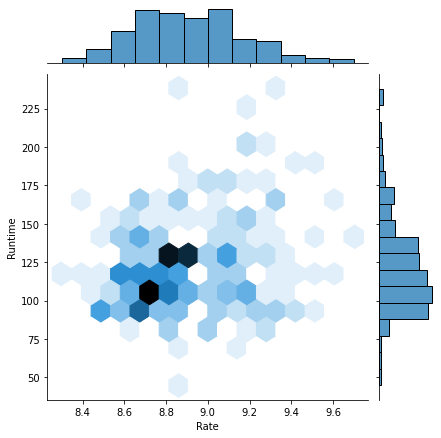

In [8]:
calc_time(douban_df)

disp_joint(douban_df, "Douban")

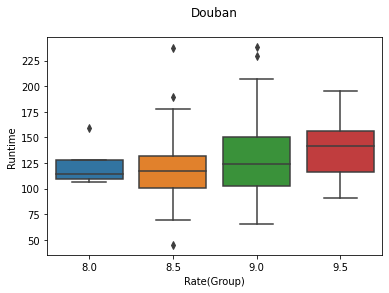

In [9]:
disp_box(douban_df, "Douban")

,RateGroup,average_time
0,9.5,NaN
1,9.0,153.400000
2,8.5,138.425532
3,8.0,127.335025


			imdb



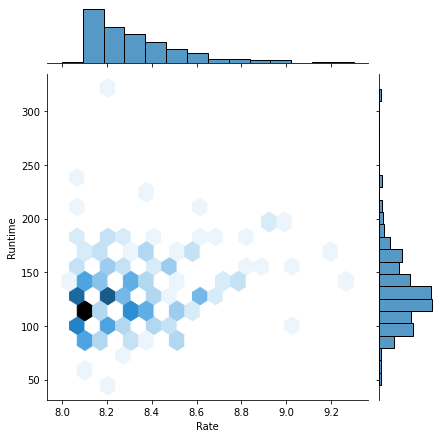

In [10]:
calc_time(imdb_df)
disp_joint(imdb_df, "imdb")

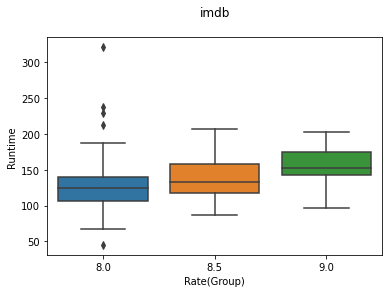

In [11]:
disp_box(imdb_df, "imdb")

In the dataframes above, the value in the RateGroup column means x or above. For example, 9.5 represents ratings from 9.5 and above, while 9.0 represents ratings from 9.0(inclusive) up to 9.5(exclusive).

We may first get a overall view about the distribution of ratings and runtime of the top 250 movies on each website from the joint-plots. Generally speaking, the scores are lower on imdb than that on Douban, while the range of both runtime and ratings are wider on imdb.

In the box-plots and the dataframes above, we are able to see that the longer the runtime is, the higher average score it may get on both websites. There are no films on the imdb website that have rates over 9.5. However, we are still able to see that the films that have the highest ratings also have the longest runtime in either dateframe. This might indicates that users on both websites prefer longer films to shorter ones. However, it may also be true that the longer the film is, the better they are in quality.

At the meantime, we can find out from the box-plots that the distribution of scores are more dispersive when the runtime gets longer on Douban, but on imdb, the range of distribution remains generally unchanged.